In [ ]:
# %tensorflow_version 1.x

In [ ]:
# !pip uninstall h5py
# !pip install h5py==2.10.0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import cv2
import keras


In [ ]:
path_org = 'drive/MyDrive/DATA_SETS/full_org'
path_forg = 'drive/MyDrive/DATA_SETS/full_forg'
count_of_persons = 55
number_of_samples = 24

def create_df():
  fake_sign = []
  for i in range(1,56):
    for j in range(1,number_of_samples+1):
      path = (path_forg+'/forgeries_'+str(i)+'_'+str(j)+'.png')
      fake_sign.append(path)

  real_sign = []
  for i in range(1,56):
    for j in range(1,number_of_samples+1):
      path = (path_org+'/original_'+str(i)+'_'+str(j)+'.png')
      real_sign.append(path)

  raw_data = {"sign_1":[], "sign_2":[], "label":[]}
  for i in range(count_of_persons):
    real_signs_1=[]
    real_signs_2=[]
    fake_signs_1=[]

    ind_start = i*24
    ind_end = (i+1)*24

    for sample in range(ind_start,ind_end):
      real_signs_1.append(real_sign[sample])
      real_signs_2.append(real_sign[sample])
      raw_data["label"].append(1)

    real_signs_1.extend(real_signs_2)

    for sign in real_signs_2:
      fake_signs_1.append(sign)

    for j in range(ind_start,ind_end):
      fake_signs_1.append(fake_sign[j])
      raw_data["label"].append(0)

    raw_data["sign_1"].extend(real_signs_1) #real-real pairs
    raw_data["sign_2"].extend(fake_signs_1)

  df = pd.DataFrame(raw_data, columns = ["sign_1","sign_2","label"])
  return df

drive/MyDrive/ML PROJECT/full_forg/forgeries_1...

In [ ]:
df = create_df()
df[22:26]

,sign_1,sign_2,label
22,drive/MyDrive/DATA_SETS/full_org/original_1_23...,drive/MyDrive/DATA_SETS/full_org/original_1_23...,1
23,drive/MyDrive/DATA_SETS/full_org/original_1_24...,drive/MyDrive/DATA_SETS/full_org/original_1_24...,1
24,drive/MyDrive/DATA_SETS/full_org/original_1_1.png,drive/MyDrive/DATA_SETS/full_forg/forgeries_1_...,0
25,drive/MyDrive/DATA_SETS/full_org/original_1_2.png,drive/MyDrive/DATA_SETS/full_forg/forgeries_1_...,0


In [ ]:
def train_test_dataset():
  data_frame = create_df()
  print(data_frame.shape)
  data_frame=data_frame.reindex(np.random.permutation(data_frame.index))
  train_set, test_set = train_test_split(data_frame,test_size=0.3,random_state=0)

  return train_set, test_set

train_set,test_set = train_test_dataset()
print(train_set.size, test_set.size)



(2640, 3)
5544 2376


In [ ]:
class SignatureSequence(keras.utils.Sequence):

    def __init__(self, df, batch_size, dim):
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.labels = df["label"]
        self.on_epoch_end()


    def __len__(self):
        s_df=self.df.shape[0]
        n=np.floor(s_df/self.batch_size)
        return int(n)

    def __getitem__(self, indis):
         #indexes
        batches = self.indises[indis*self.batch_size:(indis+1)*self.batch_size]
        items = [self.df.iloc[k] for k in batches]
        part1,part2 = self.generator(items)
        return part1,part2

    # call at the end of each epoch, randomize indices
    def on_epoch_end(self):
        self.indises = np.arange(self.df.shape[0])
        np.random.shuffle(self.indises)


    def generator(self, items):
        part_1 = np.empty((self.batch_size, *self.dim,1))#working with gray images
        part_2 = np.empty((self.batch_size, *self.dim,1))#working with gray images
        label = np.empty((self.batch_size), dtype=float)

        for i in range(len(items)):
            signature_1 = cv2.imread(items[i]["sign_1"])
            resized_signature = cv2.resize(signature_1,(220,155))
            gray_signature=cv2.cvtColor(resized_signature, cv2.COLOR_BGR2GRAY)
            ret,thr_img = cv2.threshold(gray_signature, 0, 255, cv2.THRESH_OTSU)
            normalized_signature=thr_img/255
            signature_expanded = normalized_signature[:, :, np.newaxis]
            signature_1=np.array(signature_expanded)

            signature_2 = cv2.imread(items[i]["sign_2"])
            resized_signature = cv2.resize(signature_2,(220,155))
            gray_signature=cv2.cvtColor(resized_signature, cv2.COLOR_BGR2GRAY)
            ret,thr_img = cv2.threshold(gray_signature, 0, 255, cv2.THRESH_OTSU)
            normalized_signature=thr_img/255
            signature_expanded = normalized_signature[:, :, np.newaxis]
            signature_2=np.array(signature_expanded)

            label[i] = items[i]["label"]
            part_1[i,] = signature_1
            part_2[i,] = signature_2
            y=label
            tf.cast(y, tf.float32)
            x=[part_1 ,part_2]
        return x, y





In [ ]:
dim=(155,220)
batch_size=64
data_train = SignatureSequence(train_set,batch_size,dim)
data_validation = SignatureSequence(test_set,batch_size,dim)

# Model

In [ ]:
from keras import models
from keras.layers import Conv2D, MaxPooling2D, Dense, Activation, BatchNormalization, Input, Dropout, Flatten
from keras.models import Model
from keras.models import Sequential
from keras.layers import Lambda


def network_model():
  input_shape=(155,220,1)
  in_imgLeft = Input(shape=input_shape, name="left_image")
  in_imgRight = Input(shape=input_shape, name="right_image")

  model = Sequential()
  #1st Conv layer
  model.add(Conv2D(32, (3, 3), activation="relu", input_shape=input_shape))
  model.add( MaxPooling2D(pool_size=(3,3)) )
  #2nd Conv layer
  model.add( Conv2D(64, (3, 3), activation="relu") )
  model.add( MaxPooling2D(pool_size=(3,3),strides=(2,2)) )

  #3rd Conv layer
  model.add( Conv2D(128, (3, 3), activation="relu") )
  #4st Conv layer
  model.add( Conv2D(64, (3, 3), activation="relu") )
  #5st Conv layer
  model.add( Conv2D(128, (3, 3), activation="relu") )

  model.add( MaxPooling2D(pool_size=(3,3),strides=(2,2)) )

  model.add( Dropout(0.3) )
  #Fully Connected Layer
  model.add( Flatten() )

  model.add( Dense(256, activation="relu") )
  model.add( Dropout(0.5) )

  model.add( Dense(256, activation="relu") )


  left_branch = model(in_imgLeft)
  right_branch = model(in_imgRight)

  cal = Lambda(euclidean_distance,output_shape=output_shape)
  distance=cal([left_branch, right_branch])

  model = Model([in_imgLeft, in_imgRight], distance)
  return model


In [ ]:
from keras import backend as K

def euclidean_distance(vectors):
    xi, yi = vectors
    return K.sqrt(K.sum(K.square(xi - yi), axis=1, keepdims=True))

def output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def contrastive_loss(l , y_pred):
    margin = 1
    margin_square = (K.maximum(margin - y_pred, 0))**2
    return K.mean((l * (y_pred)**2)*l + (1 - l)* margin_square)


def accuracy(y_true, y_pred):
    casted_ytrue=K.cast(y_pred < 0.5, 'float32')
    return K.mean(K.equal(y_true,casted_ytrue ))

In [ ]:
from keras.callbacks import ModelCheckpoint
import tensorflow
import tensorflow as tf
model = network_model()

In [ ]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 left_image (InputLayer)        [(None, 155, 220, 1  0           []                               
                                )]                                                                
                                                                                                  
 right_image (InputLayer)       [(None, 155, 220, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential_6 (Sequential)      (None, 256)          3714240     ['left_image[0][0]',             
                                                                  'right_image[0][0]']      

In [ ]:
optimizer = keras.optimizers.RMSprop(learning_rate=1e-4, rho=0.9, epsilon=1e-08)

In [ ]:
model.compile(loss=contrastive_loss, optimizer=optimizer,metrics=[accuracy])

In [ ]:
# history=model.fit_generator(generator=data_train,validation_data=data_validation, epochs=20,
#                             steps_per_epoch=56, validation_steps=24, use_multiprocessing=True,
#                             workers=6)

history=model.fit(data_train, epochs=20,
                            steps_per_epoch=56, validation_steps=24, use_multiprocessing=True,
                            workers=6)

Epoch 1/20
56/56 [==============================] - 521s 9s/step - loss: 0.2236 - accuracy: 0.6412
Epoch 2/20
56/56 [==============================] - 478s 8s/step - loss: 0.1694 - accuracy: 0.7492
Epoch 3/20
56/56 [==============================] - 487s 9s/step - loss: 0.1431 - accuracy: 0.7932
Epoch 4/20
56/56 [==============================] - 488s 8s/step - loss: 0.1250 - accuracy: 0.8287
Epoch 5/20
56/56 [==============================] - 488s 8s/step - loss: 0.1100 - accuracy: 0.8507
Epoch 6/20
56/56 [==============================] - 497s 9s/step - loss: 0.0974 - accuracy: 0.8644
Epoch 7/20
56/56 [==============================] - 481s 8s/step - loss: 0.0870 - accuracy: 0.8845
Epoch 8/20
56/56 [==============================] - 472s 8s/step - loss: 0.0772 - accuracy: 0.8998
Epoch 9/20
56/56 [==============================] - 476s 8s/step - loss: 0.0680 - accuracy: 0.9166
Epoch 10/20
56/56 [==============================] - 475s 8s/step - loss: 0.0638 - accuracy: 0.9233
Epoch 11/

In [ ]:
model.save("drive/MyDrive/DATA_SETS/Offline_Sign_model.h5")

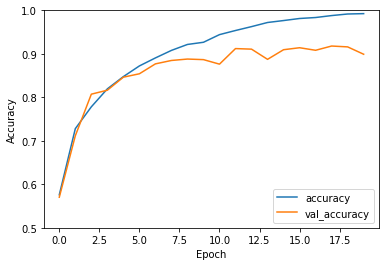

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [ ]:
test_loss, test_acc = model.evaluate(data_validation, verbose=2)

In [ ]:
test_loss

0.042131245136260986

In [ ]:
test_acc

0.9049479365348816